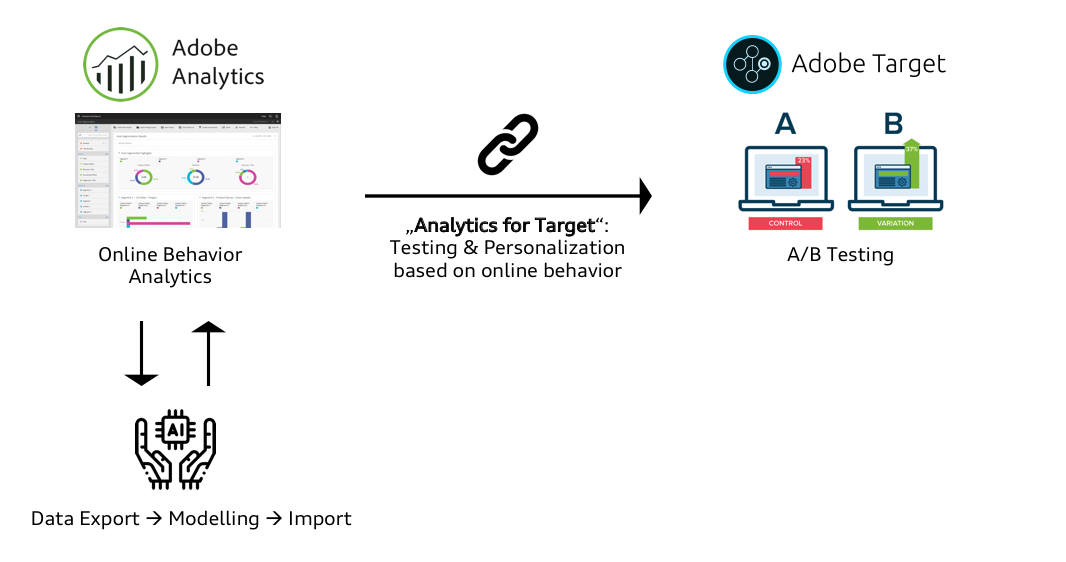

In [3]:
from IPython.display import Image
Image("target3.png")

In [1]:
import pandas as pd
import numpy as np

###############################
# Adobe Data Warehouse Import #
###############################

DATA = "data.csv"
raw_data = pd.read_csv(DATA, sep=",")
raw_data = raw_data.dropna(subset=["Marketing Cloud ID (v75) (evar75)"]).reset_index(drop=True)

###############################################
# Split and merging of column "Tracking Code" #
###############################################

campaigns = raw_data["Tracking Code"].str.split(":",expand=True)

# selection of features less than 50 different values
features = [0, 1, 2, 4, 10]
campaigns = campaigns.iloc[:, features]
campaigns.columns = ["cmp_channel", "cmp_publisher", "cmp_cat", "cmp_letter", "cmp_button"]

# merging all together
raw_data = raw_data.join(campaigns, how="outer")
raw_data = raw_data.drop(columns=["Tracking Code"])

# useful variables
numerics = ["Visits", "Page Views", "Product Search (e124) (event124)"]
categories = ["Last Touch Channel","Referring Domains", "cmp_channel", "cmp_publisher", "cmp_cat", "cmp_letter", "cmp_button"]
y = raw_data["Orders"]
ID = raw_data["Marketing Cloud ID (v75) (evar75)"]
month = raw_data["Month"]

print(raw_data.shape)

(37391, 14)


In [2]:
#############
#  dummies  #
#############
dummies_data = pd.get_dummies(data=raw_data[categories])
print(dummies_data.shape)

(37391, 312)


In [3]:
######################################
#  Split nach Monaten: train & test  #
######################################

# Zusammenfügen der dataframes
data = pd.concat([ID, month, raw_data[numerics], y, dummies_data], axis=1)
print("data Shape: ", data.shape)
print("")

# drop von alten Daten
train = ["June 2018", "July 2018", "August 2018", "September 2018", "October 2018", "November 2018"]
train_data = data[data["Month"].isin(train)]
train_data = train_data.drop(columns=["Month"])
print("train_data Shape: ", train_data.shape)

test = ["December 2018", "January 2019"]
test_data = data[data["Month"].isin(test)]
test_data = test_data.drop(columns=["Month"])
print("test_data Shape: ", test_data.shape)


#######################
#  Aggregating train  #
#######################

# aggregate & Kosmetik
train_data = train_data.groupby("Marketing Cloud ID (v75) (evar75)").agg(["sum"])
train_data.columns = ['_'.join(col) for col in train_data.columns.values]
train_data = train_data.reset_index()
train_data.columns = train_data.columns.str.replace("_sum", "")

# Update der ID & target
train_y = train_data["Orders"]
train_ID = train_data["Marketing Cloud ID (v75) (evar75)"]

# Entfernen der numerics sowie target variables
train_dummies_data = train_data.drop(columns=numerics)
train_dummies_data = train_dummies_data.drop(columns=["Orders", "Marketing Cloud ID (v75) (evar75)"])


######################
#  Aggregating test  #
######################

# aggregate & Kosmetik
test_data = test_data.groupby("Marketing Cloud ID (v75) (evar75)").agg(["sum"])
test_data.columns = ['_'.join(col) for col in test_data.columns.values]
test_data = test_data.reset_index()
test_data.columns = test_data.columns.str.replace("_sum", "")

# Update der ID & target
test_y = test_data["Orders"]
test_ID = test_data["Marketing Cloud ID (v75) (evar75)"]

# Entfernen der numerics sowie target variables
test_dummies_data = test_data.drop(columns=numerics)
test_dummies_data = test_dummies_data.drop(columns=["Orders", "Marketing Cloud ID (v75) (evar75)"])

#####################
#  printing shapes  #
#####################
print("")
print("train_data.shape: ", train_data.shape)
print("test_data.shape: ", test_data.shape)

data Shape:  (37391, 318)

train_data Shape:  (23051, 317)
test_data Shape:  (13608, 317)

train_data.shape:  (16939, 317)
test_data.shape:  (10000, 317)


In [8]:
###################
#  scaling train  #
###################
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([
        ("unwichtig", StandardScaler(), numerics)
    ])
scaled_train_data = pd.DataFrame(ct.fit_transform(train_data))


###################
#  scaling test  #
###################
scaled_test_data = pd.DataFrame(ct.fit_transform(test_data))


print("scaled_train_data.shape: ", scaled_train_data.shape)
print("")
print("scaled_test_data.shape: ", scaled_test_data.shape)

scaled_train_data.shape:  (16939, 3)

scaled_test_data.shape:  (10000, 3)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [9]:
#############################
#  final data merging train #
#############################
prep_train_data = pd.concat([train_ID, train_y, scaled_train_data, train_dummies_data], axis=1)
prep_train_data["Orders"].values[prep_train_data["Orders"] > 0] = 1

############################
#  final data merging test #
############################
prep_test_data = pd.concat([test_ID, test_y, scaled_test_data, test_dummies_data], axis=1)
prep_test_data["Orders"].values[prep_test_data["Orders"] > 0] = 1

print("prep_train_data.shape: ", prep_train_data.shape)
print("")
print("prep_test_data.shape: ", prep_test_data.shape)

prep_train_data.shape:  (16939, 317)

prep_test_data.shape:  (10000, 317)


In [10]:
#################################
#  final data preparation train #
#################################
train_ID = prep_train_data["Marketing Cloud ID (v75) (evar75)"]
train_y = prep_train_data["Orders"]
train_X = prep_train_data.drop(columns=["Marketing Cloud ID (v75) (evar75)", "Orders"])


#################################
#  final data preparation train #
#################################
test_ID = prep_test_data["Marketing Cloud ID (v75) (evar75)"]
test_y = prep_test_data["Orders"]
test_X = prep_test_data.drop(columns=["Marketing Cloud ID (v75) (evar75)", "Orders"])

print("train_X.shape: ", train_X.shape)
print("")
print("test_X.shape: ", test_X.shape)

train_X.shape:  (16939, 315)

test_X.shape:  (10000, 315)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


###################
#  Random Forest  #
###################
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_X, train_y)
prob_rf = pd.DataFrame(rf.predict_proba(test_X))
scoring_rf = prob_rf[1] 

#########
#  SVC  #
#########
svc = SVC(gamma="scale", probability=True)
svc.fit(train_X, train_y)
prob_svc = pd.DataFrame(svc.predict_proba(test_X))
scoring_svc = prob_svc[1]

#########################
#  Logistic Regression  #
#########################
logreg = LogisticRegression(solver="lbfgs")
logreg.fit(train_X, train_y)
prob_logreg = pd.DataFrame(logreg.predict_proba(test_X))
scoring_logreg = prob_logreg[1]

####################
#  KNN Classifier  #
####################
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(train_X, train_y)
prob_knn = pd.DataFrame(knn.predict_proba(test_X))
scoring_knn = prob_knn[1]

ml_scoring = pd.concat([test_ID, scoring_rf, scoring_svc, scoring_logreg, scoring_knn, test_y], axis=1)
ml_scoring.columns = ["Marketing Cloud ID (v75) (evar75)", "scoring_rf", "scoring_svc", "scoring_logreg", "scoring_knn", "test_y"]
ml_scoring["ml_scoring_average"] = ml_scoring[["scoring_rf", "scoring_svc", "scoring_logreg", "scoring_knn"]].mean(axis=1) * 100

#ml_scoring.to_csv("ml_scoring.csv", index=False)

print(ml_scoring.shape)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


(10000, 7)


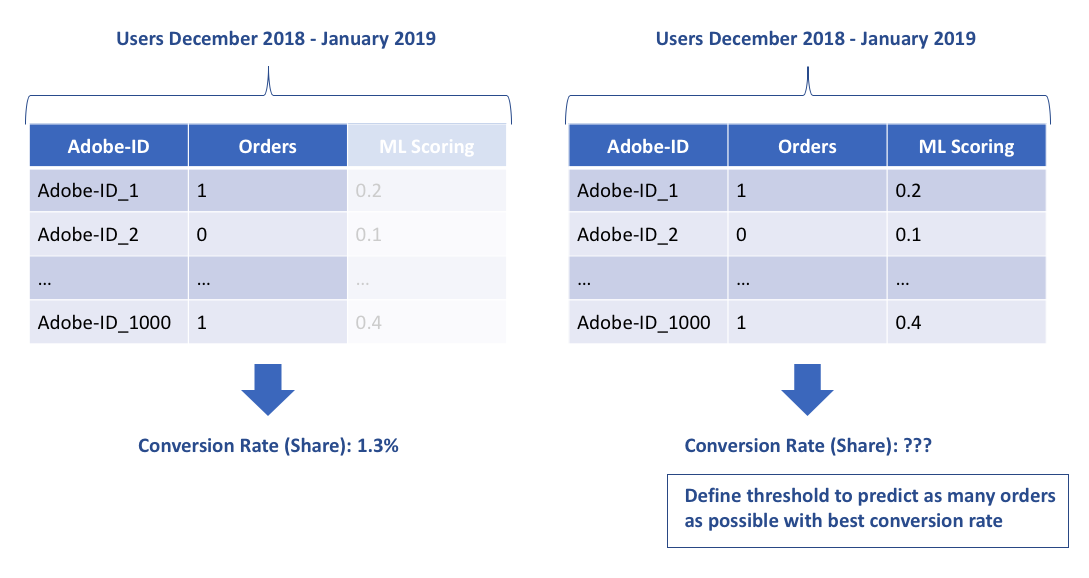

In [5]:
from IPython.display import Image
Image("scoring.png")

In [12]:
#############
#  Scoring  #
#############
print("Overall users: ", ml_scoring.shape[0])
print("Overall conversions: ", ml_scoring["test_y"].sum())
print("Overall CVR test: ", ml_scoring["test_y"].sum() / ml_scoring.shape[0])
print("")

d = []
for i in np.arange(0, ml_scoring["ml_scoring_average"].max(), 0.1):
    Orders = ml_scoring.loc[ml_scoring["ml_scoring_average"] > i, "test_y"].sum()
    Users = ml_scoring.loc[ml_scoring["ml_scoring_average"] > i, "test_y"].count()
    d.append((i, Users, Orders, Orders / Users, Orders / ml_scoring["test_y"].sum()))
    
results = pd.DataFrame(d, columns=("Threshold", "Users", "Orders", "CVR", "Orders Share"))

Overall users:  10000
Overall conversions:  130
Overall CVR test:  0.013



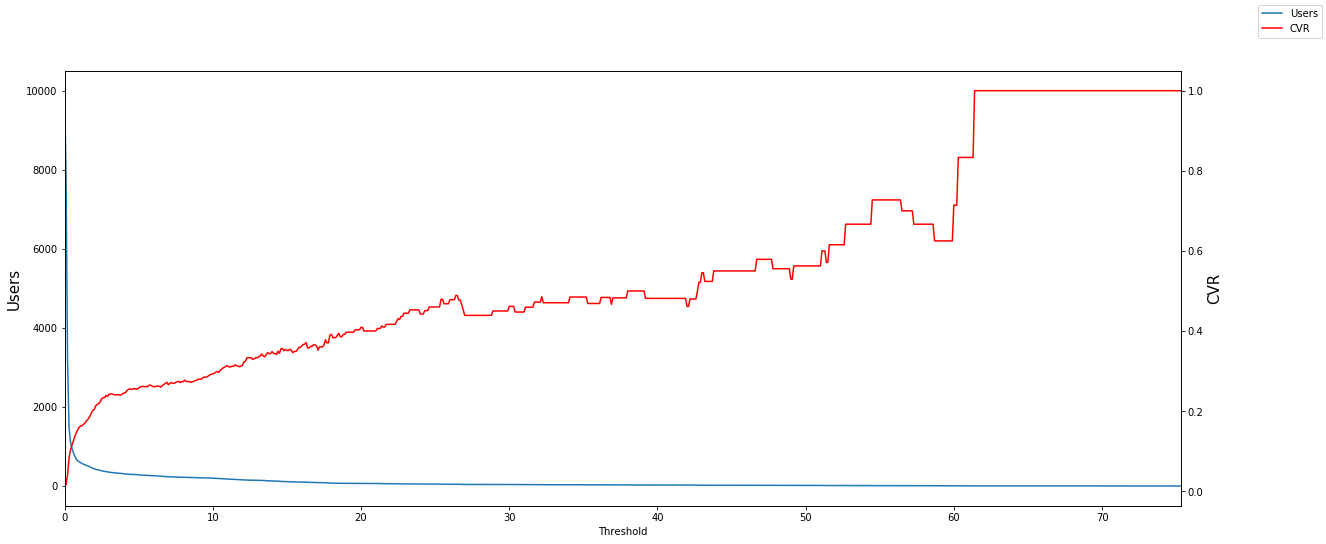

In [13]:
###################
#  Visualization  #
###################
import matplotlib.pyplot as plt
%matplotlib inline

results_plot = results.head(5000)


ax = results_plot.plot(x="Threshold", y="Users", legend=False)
ax.set_ylabel("Users", fontsize=15)
ax2 = ax.twinx()
ax2.set_ylabel("CVR", fontsize=15)
results_plot.plot(x="Threshold", y="CVR", ax=ax2, legend=False, color="r", figsize=(20, 8))
ax.figure.legend()
plt.show()

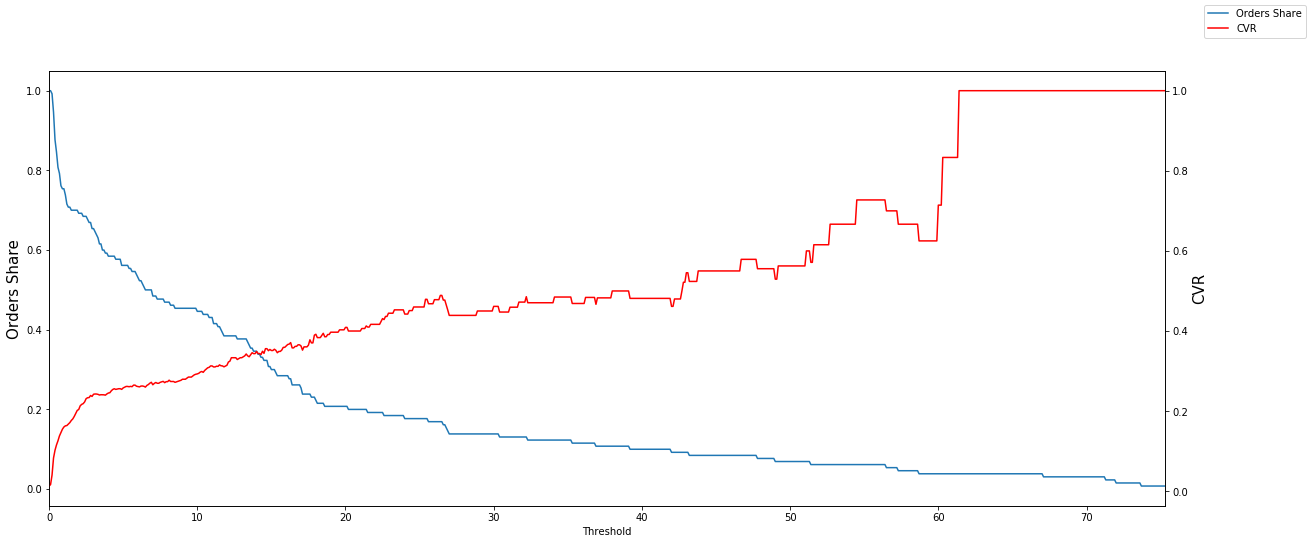

In [14]:
###################
#  Visualization  #
###################
import matplotlib.pyplot as plt
%matplotlib inline

results_plot = results.head(5000)


ax = results_plot.plot(x="Threshold", y="Orders Share", legend=False)
ax.set_ylabel("Orders Share", fontsize=15)
ax2 = ax.twinx()
ax2.set_ylabel("CVR", fontsize=15)
results_plot.plot(x="Threshold", y="CVR", ax=ax2, legend=False, color="r", figsize=(20, 8))
ax.figure.legend()
plt.show()